# Task discribtion

In this homework, we will firstly develop a 2D path planning by bi-rrt* based on octree, then smooth this path though BFSG algorithm.

## Enviroment setup
We will define the 2D arena firstly, and the obstacles are represented as circle.

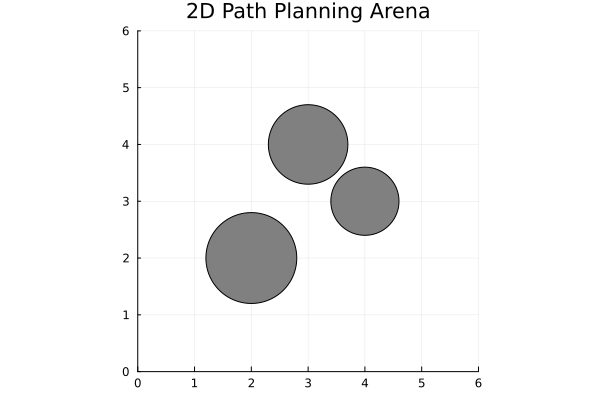

In [17]:
using Plots

# 定义障碍物（圆形）：每个障碍物由中心 (x, y) 和半径 r 表示
struct CircleObstacle
    x::Float64
    y::Float64
    r::Float64
end

# 定义八叉树节点（这里只实现四叉树，适用于2D场景）
mutable struct QuadTreeNode
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
    obstacles::Vector{CircleObstacle}
    children::Union{Nothing, Vector{QuadTreeNode}}
end

# 判断圆是否与矩形区域相交
function circle_intersects_rect(circle::CircleObstacle, xmin, xmax, ymin, ymax)
    x = max(xmin, min(circle.x, xmax))
    y = max(ymin, min(circle.y, ymax))
    (circle.x - x)^2 + (circle.y - y)^2 <= circle.r^2
end

# 构建四叉树
function build_quadtree(xmin, xmax, ymin, ymax, obstacles, depth=0, max_depth=5)
    node = QuadTreeNode(xmin, xmax, ymin, ymax, CircleObstacle[], nothing)
    for obs in obstacles
        if circle_intersects_rect(obs, xmin, xmax, ymin, ymax)
            push!(node.obstacles, obs)
        end
    end
    if depth < max_depth && length(node.obstacles) > 1
        xmid = (xmin + xmax) / 2
        ymid = (ymin + ymax) / 2
        node.children = [
            build_quadtree(xmin, xmid, ymin, ymid, node.obstacles, depth+1, max_depth),
            build_quadtree(xmid, xmax, ymin, ymid, node.obstacles, depth+1, max_depth),
            build_quadtree(xmin, xmid, ymid, ymax, node.obstacles, depth+1, max_depth),
            build_quadtree(xmid, xmax, ymid, ymax, node.obstacles, depth+1, max_depth)
        ]
    end
    return node
end

# 示例障碍物
obstacles = [
    CircleObstacle(2.0, 2.0, 0.8),
    CircleObstacle(4.0, 3.0, 0.6),
    CircleObstacle(3.0, 4.0, 0.7)
]

# 构建四叉树
arena_bounds = (xmin=0.0, xmax=6.0, ymin=0.0, ymax=6.0)
quadtree = build_quadtree(arena_bounds.xmin, arena_bounds.xmax, arena_bounds.ymin, arena_bounds.ymax, obstacles)

# 可视化场景
plot(; xlim=(arena_bounds.xmin, arena_bounds.xmax), ylim=(arena_bounds.ymin, arena_bounds.ymax), aspect_ratio=1, legend=false, title="2D Path Planning Arena")
for obs in obstacles
    θ = range(0, 2π, length=100)
    plot!(obs.x .+ obs.r*cos.(θ), obs.y .+ obs.r*sin.(θ), fill=(0, :gray), linecolor=:black)
end
display(current())

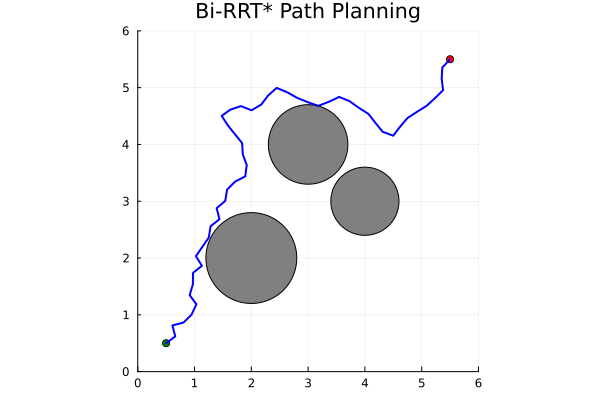

In [18]:
using Random

# 定义节点结构体
mutable struct RRTNode
    x::Float64
    y::Float64
    parent::Union{Nothing, RRTNode}
end

# 检查线段是否与任一障碍物碰撞
function is_collision(x1, y1, x2, y2, obstacles)
    for obs in obstacles
        # 最近点到圆心距离
        dx, dy = x2 - x1, y2 - y1
        fx, fy = x1 - obs.x, y1 - obs.y
        a = dx^2 + dy^2
        b = 2 * (fx*dx + fy*dy)
        c = fx^2 + fy^2 - obs.r^2
        discriminant = b^2 - 4*a*c
        if discriminant < 0
            continue
        end
        discriminant = sqrt(discriminant)
        t1 = (-b - discriminant) / (2*a)
        t2 = (-b + discriminant) / (2*a)
        if (0 ≤ t1 ≤ 1) || (0 ≤ t2 ≤ 1)
            return true
        end
    end
    return false
end

# 采样随机点
function sample_free(bounds)
    x = rand() * (bounds.xmax - bounds.xmin) + bounds.xmin
    y = rand() * (bounds.ymax - bounds.ymin) + bounds.ymin
    return x, y
end

# 找到最近节点
function nearest(tree, x, y)
    dmin, nmin = Inf, nothing
    for node in tree
        d = (node.x - x)^2 + (node.y - y)^2
        if d < dmin
            dmin, nmin = d, node
        end
    end
    return nmin
end

# 扩展树
function steer(from::RRTNode, to_x, to_y, step_size)
    θ = atan(to_y - from.y, to_x - from.x)
    nx = from.x + step_size * cos(θ)
    ny = from.y + step_size * sin(θ)
    return nx, ny
end

# 检查是否到达目标
function reached_goal(node, goal, threshold)
    return hypot(node.x - goal.x, node.y - goal.y) < threshold
end

# 路径回溯
function extract_path(node)
    path = []
    while node !== nothing
        push!(path, (node.x, node.y))
        node = node.parent
    end
    reverse!(path)
    return path
end

# Bi-RRT*主函数（简化版）
function birrt_star(start_xy, goal_xy, obstacles, bounds; max_iter=1000, step_size=0.2, goal_threshold=0.3)
    start_node = RRTNode(start_xy[1], start_xy[2], nothing)
    goal_node = RRTNode(goal_xy[1], goal_xy[2], nothing)
    tree_start = [start_node]
    tree_goal = [goal_node]
    path = nothing

    for iter in 1:max_iter
        # 采样
        x_rand, y_rand = sample_free(bounds)
        # 扩展start树
        nearest_start = nearest(tree_start, x_rand, y_rand)
        nx, ny = steer(nearest_start, x_rand, y_rand, step_size)
        if !is_collision(nearest_start.x, nearest_start.y, nx, ny, obstacles)
            new_node = RRTNode(nx, ny, nearest_start)
            push!(tree_start, new_node)
            # 尝试连接goal树
            nearest_goal = nearest(tree_goal, nx, ny)
            if !is_collision(nearest_goal.x, nearest_goal.y, nx, ny, obstacles) &&
               hypot(nearest_goal.x - nx, nearest_goal.y - ny) < step_size
                # 路径找到
                if tree_start[1] === start_node
                    path1 = extract_path(new_node)
                    path2 = extract_path(nearest_goal)
                else
                    path1 = extract_path(nearest_goal)
                    path2 = extract_path(new_node)
                end
                path = vcat(path1, reverse(path2))
                break
            end
        end
        # 交换树
        tree_start, tree_goal = tree_goal, tree_start
    end
    return path
end

# 设置起点和终点
start_xy = (0.5, 0.5)
goal_xy = (5.5, 5.5)

# 计算路径
path = birrt_star(start_xy, goal_xy, obstacles, arena_bounds)

# 可视化
plot(; xlim=(arena_bounds.xmin, arena_bounds.xmax), ylim=(arena_bounds.ymin, arena_bounds.ymax), aspect_ratio=1, legend=false, title="Bi-RRT* Path Planning")
for obs in obstacles
    θ = range(0, 2π, length=100)
    plot!(obs.x .+ obs.r*cos.(θ), obs.y .+ obs.r*sin.(θ), fill=(0, :gray), linecolor=:black)
end
scatter!([start_xy[1]], [start_xy[2]], color=:green, label="Start")
scatter!([goal_xy[1]], [goal_xy[2]], color=:red, label="Goal")
if path !== nothing
    plot!([p[1] for p in path], [p[2] for p in path], color=:blue, lw=2, label="Path")
end
display(current())

In [19]:
import Pkg; Pkg.add("Interpolations")
import Pkg; Pkg.add("Optim")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


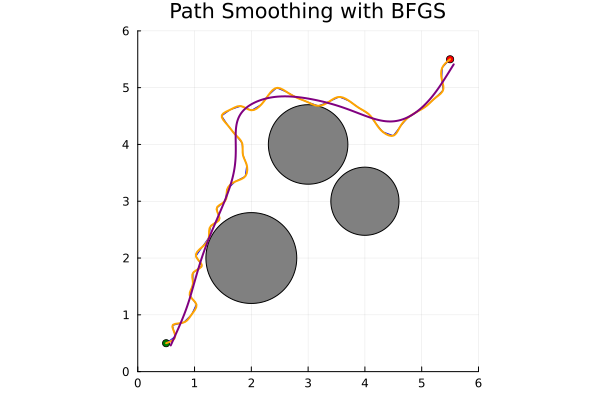

In [22]:
using Interpolations, Optim

# 三次样条插值
function cubic_spline_path(path)
    xs = [p[1] for p in path]
    ys = [p[2] for p in path]
    ts = cumsum([0; hypot.(diff(xs), diff(ys))])  # 路径长度参数化
    t_range = range(ts[1], ts[end], length=length(ts))
    itp_x = cubic_spline_interpolation(t_range, xs)
    itp_y = cubic_spline_interpolation(t_range, ys)
    t_dense = range(ts[1], ts[end], length=200)
    x_dense = itp_x.(t_dense)
    y_dense = itp_y.(t_dense)
    return x_dense, y_dense
end

# BFGS平滑优化目标
function smooth_cost(z, x_ref, y_ref, λ=1.0)
    n = length(x_ref)
    x = z[1:n]
    y = z[n+1:end]
    # 距离原始点的代价
    cost = sum((x .- x_ref).^2 .+ (y .- y_ref).^2)
    # 平滑项（曲率）
    cost += λ * sum((diff(diff(x))).^2 .+ (diff(diff(y))).^2)
    return cost
end

# 对三次样条插值结果进行BFGS平滑
function bfgs_smooth(x_dense, y_dense)
    n = length(x_dense)
    z0 = vcat(x_dense, y_dense)
    result = optimize(z -> smooth_cost(z, x_dense, y_dense, 10000.0), z0, BFGS())
    z_opt = Optim.minimizer(result)
    x_opt = z_opt[1:n]
    y_opt = z_opt[n+1:end]
    return x_opt, y_opt
end

if path !== nothing
    x_dense, y_dense = cubic_spline_path(path)
    x_smooth, y_smooth = bfgs_smooth(x_dense, y_dense)

    # 可视化
    plot(; xlim=(arena_bounds.xmin, arena_bounds.xmax), ylim=(arena_bounds.ymin, arena_bounds.ymax), aspect_ratio=1, legend=false, title="Path Smoothing with BFGS")
    for obs in obstacles
        θ = range(0, 2π, length=100)
        plot!(obs.x .+ obs.r*cos.(θ), obs.y .+ obs.r*sin.(θ), fill=(0, :gray), linecolor=:black)
    end
    scatter!([start_xy[1]], [start_xy[2]], color=:green, label="Start")
    scatter!([goal_xy[1]], [goal_xy[2]], color=:red, label="Goal")
    plot!([p[1] for p in path], [p[2] for p in path], color=:blue, lw=1, label="Original Path")
    plot!(x_dense, y_dense, color=:orange, lw=2, label="Cubic Spline")
    plot!(x_smooth, y_smooth, color=:purple, lw=2, label="BFGS Smoothed")
    display(current())
end


## 三次样条曲线与BFGS平滑过程说明

### 三次样条曲线穿越指定点

如图所示，三次样条曲线依次穿越 $x_0, x_1, \ldots, x_N$，其参数形式如下：

- $a_i = x_i$
- $b_i = D_i$
- $c_i = 3(x_{i+1} - x_i) - 2D_i - D_{i+1}$
- $d_i = 2(x_i - x_{i+1}) + D_i + D_{i+1}$

其中 $D_i$ 由如下线性方程组求解：

$$
\begin{bmatrix}
4 & 1 & 0 & \cdots & 0 \\
1 & 4 & 1 & \cdots & 0 \\
0 & 1 & 4 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & 1 \\
0 & 0 & 0 & 1 & 4
\end{bmatrix}
\begin{bmatrix}
D_1 \\ D_2 \\ D_3 \\ \vdots \\ D_{n-1}
\end{bmatrix}
=
\begin{bmatrix}
3(x_2 - x_0) \\
3(x_3 - x_1) \\
3(x_4 - x_2) \\
\vdots \\
3(x_n - x_{n-2})
\end{bmatrix}
$$

边界条件 $D_0 = D_N = 0$。



### 三次样条曲线参数说明

对于通过 $x_0, x_1, \ldots, x_N$ 的三次样条曲线，每一段 $[x_i, x_{i+1}]$ 上的样条可以写为：
$$
S_i(t) = a_i + b_i t + c_i t^2 + d_i t^3, \quad t \in [0, 1]
$$

其中参数含义如下：

- $a_i = x_i$：该段的起点坐标
- $b_i = D_i$：该点的导数（斜率），即 $S_i'(0)$
- $c_i = 3(x_{i+1} - x_i) - 2D_i - D_{i+1}$：由端点和导数确定
- $d_i = 2(x_i - x_{i+1}) + D_i + D_{i+1}$：由端点和导数确定

这里的 $D_i$ 表示样条在节点 $x_i$ 处的导数（斜率），是保证曲线一阶、二阶连续的关键参数。

### $c_i$ 和 $d_i$ 的详细推导

对于每一段三次样条 $S_i(t)$，其表达式为：
$$
S_i(t) = a_i + b_i t + c_i t^2 + d_i t^3, \quad t \in [0, 1]
$$

要求样条在每个节点处函数值和一阶导数连续，即满足以下条件：

1. $S_i(0) = x_i$
2. $S_i(1) = x_{i+1}$
3. $S_i'(0) = D_i$
4. $S_i'(1) = D_{i+1}$

将 $t=0,1$ 代入上式，得到：

- $S_i(0) = a_i = x_i$
- $S_i(1) = a_i + b_i + c_i + d_i = x_{i+1}$
- $S_i'(t) = b_i + 2c_i t + 3d_i t^2$
- $S_i'(0) = b_i = D_i$
- $S_i'(1) = b_i + 2c_i + 3d_i = D_{i+1}$

整理得：

1. $a_i = x_i$
2. $b_i = D_i$
3. $a_i + b_i + c_i + d_i = x_{i+1}$
4. $b_i + 2c_i + 3d_i = D_{i+1}$

将 $a_i$ 和 $b_i$ 代入第3、4式：

- $x_i + D_i + c_i + d_i = x_{i+1} \implies c_i + d_i = x_{i+1} - x_i - D_i$
- $D_i + 2c_i + 3d_i = D_{i+1} \implies 2c_i + 3d_i = D_{i+1} - D_i$

联立这两个方程，解 $c_i$ 和 $d_i$：

第一个方程：$c_i + d_i = x_{i+1} - x_i - D_i$  
第二个方程：$2c_i + 3d_i = D_{i+1} - D_i$

用第一个方程消去 $c_i$：

$2c_i + 3d_i = D_{i+1} - D_i$  
$2(c_i + d_i) + d_i = D_{i+1} - D_i$  
$2(x_{i+1} - x_i - D_i) + d_i = D_{i+1} - D_i$  
$2(x_{i+1} - x_i - D_i) + d_i = D_{i+1} - D_i$  
$d_i = D_{i+1} - D_i - 2(x_{i+1} - x_i - D_i)$  
$d_i = D_{i+1} - D_i - 2x_{i+1} + 2x_i + 2D_i$  
$d_i = D_{i+1} + D_i + 2x_i - 2x_{i+1}$  
$d_i = 2(x_i - x_{i+1}) + D_i + D_{i+1}$

再代入 $c_i = x_{i+1} - x_i - D_i - d_i$：

$c_i = x_{i+1} - x_i - D_i - [2(x_i - x_{i+1}) + D_i + D_{i+1}]$  
$c_i = x_{i+1} - x_i - D_i - 2x_i + 2x_{i+1} - D_i - D_{i+1}$  
$c_i = 3(x_{i+1} - x_i) - 2D_i - D_{i+1}$

因此，$c_i$ 和 $d_i$ 的公式推导如下：

- $c_i = 3(x_{i+1} - x_i) - 2D_i - D_{i+1}$
- $d_i = 2(x_i - x_{i+1}) + D_i + D_{i+1}$

这就是三次样条插值中 $c_i$ 和 $d_i$ 的由来。

#### $D_i$ 的求解方式

为了保证三次样条曲线在每个节点处一阶、二阶导数连续，需要对每个内部节点 $x_i$（$i=1,2,\ldots,n-1$）的导数 $D_i$ 建立方程。具体推导如下：

对于每一段 $[x_{i-1}, x_i]$ 和 $[x_i, x_{i+1}]$，要求在 $x_i$ 处二阶导数连续，即 $S_{i-1}''(1) = S_i''(0)$。根据三次样条的参数表达式 $S_i(t) = a_i + b_i t + c_i t^2 + d_i t^3$，其二阶导数为 $S_i''(t) = 2c_i + 6d_i t$。

- $S_{i-1}''(1) = 2c_{i-1} + 6d_{i-1}$
- $S_i''(0) = 2c_i$

令二阶导数在 $x_i$ 处连续，有 $2c_{i-1} + 6d_{i-1} = 2c_i$。

将 $c_i$ 和 $d_i$ 的表达式代入，整理后可得关于 $D_{i-1}, D_i, D_{i+1}$ 的线性方程：

$$
4D_i + D_{i+1} + D_{i-1} = 3(x_{i+1} - x_{i-1})
$$

对所有内部节点 $i=1,2,\ldots,n-1$ 建立上述方程，结合两端的自然边界条件 $D_0 = D_n = 0$，即可得到如下三对角线性方程组：

$$
\begin{bmatrix}
4 & 1 & 0 & \cdots & 0 \\
1 & 4 & 1 & \cdots & 0 \\
0 & 1 & 4 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & 1 \\
0 & 0 & 0 & 1 & 4
\end{bmatrix}
\begin{bmatrix}
D_1 \\ D_2 \\ D_3 \\ \vdots \\ D_{n-1}
\end{bmatrix}
=
\begin{bmatrix}
3(x_2 - x_0) \\
3(x_3 - x_1) \\
3(x_4 - x_2) \\
\vdots \\
3(x_n - x_{n-2})
\end{bmatrix}
$$

其中 $n = N$，$D_0$ 和 $D_N$ 通常取为 $0$（自然边界条件）。

### 链式法则推导

根据链式法则，$d_i$ 和 $c_i$ 对 $x$ 的导数为：

$$
\frac{dd_i}{dx} = 2 \frac{d(x_i - x_{i+1})}{dx} + \frac{dD_i}{dx} + \frac{dD_{i+1}}{dx}
$$

$$
\frac{dc_i}{dx} = 3 \frac{d(x_{i+1} - x_i)}{dx} - 2\frac{dD_i}{dx} - \frac{dD_{i+1}}{dx}
$$

其中，差分向量对 $x$ 的导数为：

$$
\frac{d}{dx}
\begin{pmatrix}
x_0 - x_1 \\
x_1 - x_2 \\
\vdots \\
x_{n-1} - x_n
\end{pmatrix}
=
\begin{pmatrix}
-1 & 1 & 0 & \cdots & 0 \\
0 & -1 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & 0 \\
0 & 0 & 0 & -1 & 1
\end{pmatrix}
$$

在其中，

$$
\frac{d}{dx}
\begin{pmatrix}
x_0 - x_1 \\
\vdots \\
x_{i-1} - x_i \\
\vdots \\
x_{n-1} - x_n
\end{pmatrix}_{n \times 1}
=
\begin{pmatrix}
-1 & \\
1 & -1 & \\
& 1 & -1 & \\
& & \ddots & \ddots & \\
& & & 1 & -1 \\
& & & & 1
\end{pmatrix}_{n \times (n-1)}
$$

我们可以简化符号如下：

$$
B_{(n-1)\times1} = 3
\begin{bmatrix}
x_2 - x_0 \\
x_3 - x_1 \\
x_4 - x_2 \\
x_5 - x_3 \\
\vdots \\
x_{n-1} - x_{n-3} \\
x_n - x_{n-2}
\end{bmatrix}_{(n-1)\times1}
\qquad
D_{(n-1)\times1} =
\begin{bmatrix}
D_1 \\
D_2 \\
D_3 \\
D_4 \\
\vdots \\
D_{n-2} \\
D_{n-1}
\end{bmatrix}_{(n-1)\times1}
$$

$$
A_{(n-1)\times(n-1)} =
\begin{pmatrix}
4 & 1 \\
1 & 4 & 1 \\
& 1 & 4 & 1 \\
& & \ddots & \ddots & \ddots \\
& & & 1 & 4 & 1 \\
& & & & 1 & 4
\end{pmatrix}_{(n-1)\times(n-1)}
$$

因此有 $D = A^{-1}B$，其中 $A$ 为常数矩阵。

### $D$ 对 $x$ 的导数

由于 $D = A^{-1}B$，$A$ 为常数矩阵，有：

$$
\frac{dD}{dx} = A^{-1} \frac{dB}{dx}
$$

其中

$$
\frac{dB}{dx} =
\begin{pmatrix}
0 & 3 & 0 & \cdots & 0 \\
-3 & 0 & 3 & \cdots & 0 \\
0 & -3 & 0 & 3 & 0 \\
\vdots & \vdots & \vdots & \ddots & 3 \\
0 & 0 & 0 & -3 & 0
\end{pmatrix}
$$

### BFGS 平滑优化过程

BFGS（Broyden-Fletcher-Goldfarb-Shanno）是一种拟牛顿法，用于无约束优化。其在路径平滑中的应用流程如下：

1. **定义目标函数**：平滑代价函数通常包括拟合项和曲率项，例如
    $$
    J(x, y) = \sum_i \left[(x_i - x_{i,ref})^2 + (y_i - y_{i,ref})^2\right] + \lambda \sum_i \left[(x_{i+1} - 2x_i + x_{i-1})^2 + (y_{i+1} - 2y_i + y_{i-1})^2\right]
    $$
2. **计算梯度**：对 $x$ 和 $y$ 分别求导，得到梯度向量。
3. **BFGS 迭代**：
    - 初始化 $x_0$，Hessian 近似 $H_0=I$。
    - 计算下降方向 $p_k = -H_k \nabla J(x_k)$。
    - 线搜索确定步长 $\alpha_k$。
    - 更新 $x_{k+1} = x_k + \alpha_k p_k$。
    - 更新 Hessian 近似 $H_{k+1}$。
    - 重复直到收敛。

4. **输出平滑路径**：最终 $x^*, y^*$ 即为平滑后的路径点。

在本实验中，既可以调用 Optim 包的 BFGS，也可以手动实现 BFGS 算法，二者原理一致。



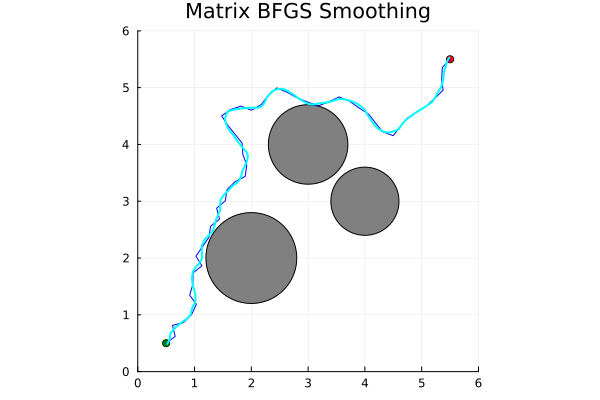

In [39]:
using LinearAlgebra

# 构造三对角矩阵A和右端项B，解三次样条的D参数
function cubic_spline_D(x::Vector{Float64})
    n = length(x) - 1
    if n < 2
        return zeros(length(x))
    end
    # 构造A矩阵 (n-1)x(n-1)
    A = zeros(n-1, n-1)
    for i in 1:n-1
        A[i,i] = 4
        if i > 1
            A[i,i-1] = 1
        end
        if i < n-1
            A[i,i+1] = 1
        end
    end
    # 构造B向量
    B = zeros(n-1)
    for i in 1:n-1
        B[i] = 3 * (x[i+2] - x[i])
    end
    # 求解 D_1~D_{n-1}
    D_inner = A \ B
    D = zeros(length(x))
    D[2:end-1] = D_inner
    return D
end

# 三次样条插值（矩阵表达）
function cubic_spline_path_matrix(path)
    xs = [p[1] for p in path]
    ys = [p[2] for p in path]
    D_x = cubic_spline_D(xs)
    D_y = cubic_spline_D(ys)
    N = length(xs) - 1
    t_dense = range(0, N, length=200)
    x_dense = similar(t_dense)
    y_dense = similar(t_dense)
    for (j, t) in enumerate(t_dense)
        i = clamp(floor(Int, t), 1, N)
        τ = t - (i-1)
        # 样条参数
        a_x, b_x, c_x, d_x = xs[i], D_x[i], 3*(xs[i+1]-xs[i])-2*D_x[i]-D_x[i+1], 2*(xs[i]-xs[i+1])+D_x[i]+D_x[i+1]
        a_y, b_y, c_y, d_y = ys[i], D_y[i], 3*(ys[i+1]-ys[i])-2*D_y[i]-D_y[i+1], 2*(ys[i]-ys[i+1])+D_y[i]+D_y[i+1]
        x_dense[j] = a_x + b_x*τ + c_x*τ^2 + d_x*τ^3
        y_dense[j] = a_y + b_y*τ + c_y*τ^2 + d_y*τ^3
    end
    return x_dense, y_dense
end

# 二阶差分矩阵（用于曲率项）
function diff2_matrix(n)
    # 生成(n-2)x n的二阶差分矩阵
    D2 = zeros(n-2, n)
    for i in 1:n-2
        D2[i, i]   = 1
        D2[i, i+1] = -2
        D2[i, i+2] = 1
    end
    return D2
end

# 平滑代价函数（矩阵表达）
function smooth_cost_mat(z, x_ref, y_ref, λ=1.0)
    n = length(x_ref)
    x = z[1:n]
    y = z[n+1:end]
    # 拟合项
    cost = sum((x .- x_ref).^2 .+ (y .- y_ref).^2)
    # 曲率项（用二阶差分矩阵）
    D2 = diff2_matrix(n)
    cost += λ * (sum((D2*x).^2) + sum((D2*y).^2))
    return cost
end

# 平滑代价梯度（矩阵表达）
function smooth_cost_grad_mat(z, x_ref, y_ref, λ=1.0)
    n = length(x_ref)
    x = z[1:n]
    y = z[n+1:end]
    D2 = diff2_matrix(n)
    # 拟合项梯度
    grad_x = 2 .* (x .- x_ref)
    grad_y = 2 .* (y .- y_ref)
    # 曲率项梯度
    grad_x += 2λ .* (D2' * (D2 * x))
    grad_y += 2λ .* (D2' * (D2 * y))
    return vcat(grad_x, grad_y)
end

# 手动BFGS算法（不依赖Optim包）
function manual_bfgs(f, grad_f, x0; max_iter=100, tol=1e-6)
    n = length(x0)
    x = copy(x0)
    H = Matrix{Float64}(I, n, n)
    g = grad_f(x)
    for iter = 1:max_iter
        if norm(g) < tol
            break
        end
        p = -H * g
        α = 1.0
        # 回溯线搜索
        while f(x + α*p) > f(x) + 1e-4*α*dot(g, p)
            α *= 0.5
            if α < 1e-8
                break
            end
        end
        s = α * p
        x_new = x + s
        g_new = grad_f(x_new)
        y = g_new - g
        ρ = 1 / (dot(y, s) + 1e-12)
        V = Matrix{Float64}(I, n, n) - ρ * s * y'
        H = V * H * V' + ρ * s * s'
        x, g = x_new, g_new
    end
    return x
end

# 使用矩阵表达的BFGS平滑
function manual_bfgs_smooth_matrix(x_ref, y_ref, λ=100)
    n = length(x_ref)
    z0 = vcat(x_ref, y_ref)
    f = z -> smooth_cost_mat(z, x_ref, y_ref, λ)
    grad_f = z -> smooth_cost_grad_mat(z, x_ref, y_ref, λ)
    z_opt = manual_bfgs(f, grad_f, z0)
    x_opt = z_opt[1:n]
    y_opt = z_opt[n+1:end]
    return x_opt, y_opt
end

# 示例：对已有路径进行三次样条+矩阵BFGS平滑
if path !== nothing
    x_dense, y_dense = cubic_spline_path_matrix(path)
    x_smooth3, y_smooth3 = manual_bfgs_smooth_matrix(x_dense, y_dense)

    # 可视化
    plot(; xlim=(arena_bounds.xmin, arena_bounds.xmax), ylim=(arena_bounds.ymin, arena_bounds.ymax), aspect_ratio=1, legend=false, title="Matrix BFGS Smoothing")
    for obs in obstacles
        θ = range(0, 2π, length=100)
        plot!(obs.x .+ obs.r*cos.(θ), obs.y .+ obs.r*sin.(θ), fill=(0, :gray), linecolor=:black)
    end
    scatter!([start_xy[1]], [start_xy[2]], color=:green, label="Start")
    scatter!([goal_xy[1]], [goal_xy[2]], color=:red, label="Goal")
    plot!([p[1] for p in path], [p[2] for p in path], color=:blue, lw=1, label="Original Path")
    # plot!(x_dense, y_dense, color=:orange, lw=2, label="Cubic Spline")
    plot!(x_smooth3, y_smooth3, color=:cyan, lw=2, label="Matrix BFGS Smoothed")
    display(current())
end